                     Domain  Having_@_symbol  Having_IP  \
0  www.liquidgeneration.com                0          0   
1       www.onlineanime.org                0          0   
2       www.ceres.dti.ne.jp                0          0   
3            www.galeon.com                0          0   
4       www.fanworkrecs.com                0          0   

                          Path  Prefix_suffix_separation Protocol  \
0                            /                         0     http   
1                            /                         0     http   
2  /~nekoi/senno/senfirst.html                         0     http   
3                        /kmh/                         0     http   
4                            /                         0     http   

   Redirection_//_symbol  Sub_domains  URL_Length  age_domain  dns_record  \
0                      0            0           0           0           0   
1                      0            0           0           0           0   

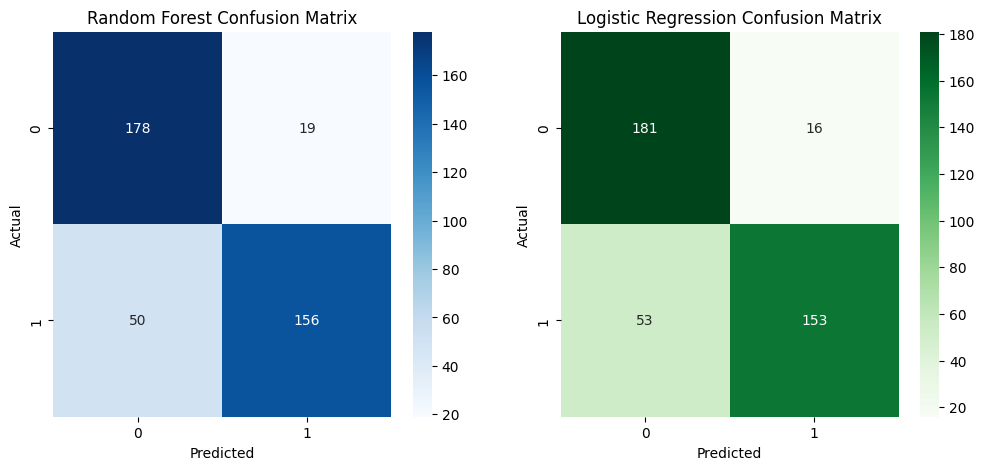

URL: https://www.google.com - RF Prediction: Legitimate, LR Prediction: Legitimate
URL: https://www.facebook.com - RF Prediction: Phishing, LR Prediction: Phishing
URL: https://www.phishing-website.com - RF Prediction: Phishing, LR Prediction: Legitimate
URL: https://www.legitimate-website.com - RF Prediction: Phishing, LR Prediction: Legitimate


In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

legitimate_urls = pd.read_csv('legitimate-urls.csv')
phishing_urls = pd.read_csv('phishing-urls.csv')

legitimate_urls['label'] = 0  
phishing_urls['label'] = 1    

df = pd.concat([legitimate_urls, phishing_urls], ignore_index=True)

print(df.head())


def preprocess_url(url):
    url = url.lower()
    url = re.sub(r'https?://', '', url)
    url = re.sub(r'www\.', '', url)
    url = re.sub(r'[^a-zA-Z0-9]', ' ', url)
    return url

df['processed_url'] = df['Domain'].apply(preprocess_url)


vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['processed_url']).toarray()
y = df['label'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))


lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr))


joblib.dump(rf_model, 'random_forest_model.pkl')
joblib.dump(lr_model, 'logistic_regression_model.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')

cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_lr = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

test_urls = ['https://www.google.com', 'https://www.facebook.com', 'https://www.phishing-website.com', 'https://www.legitimate-website.com']
test_urls_processed = [preprocess_url(url) for url in test_urls]
test_features = vectorizer.transform(test_urls_processed).toarray()
rf_predictions = rf_model.predict(test_features)
lr_predictions = lr_model.predict(test_features)

for url, rf_pred, lr_pred in zip(test_urls, rf_predictions, lr_predictions):
    print(f'URL: {url} - RF Prediction: {"Phishing" if rf_pred == 1 else "Legitimate"}, LR Prediction: {"Phishing" if lr_pred == 1 else "Legitimate"}')
